In [197]:
import torch
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pandas as pd

In [229]:
PATH = './training_results/best_4' # An example result

In [230]:
def get_path(file_name):
    return os.path.join(PATH, file_name)

### **Load Training** Results

In [231]:
with open(get_path('mlp_performance.pkl'), 'rb') as f:
    model_performance_dict = pickle.load(f)

In [232]:
model_performance_dict['train_acc'] = [t for t in model_performance_dict['train_acc']]
model_performance_dict['valid_acc'] = [t for t in model_performance_dict['valid_acc']]

### **Load DAVinz** Results

In [233]:
with open(get_path('davinz_results.pkl'), 'rb') as f:
    davinz_results_dict = pickle.load(f)

(17,)
(18,)


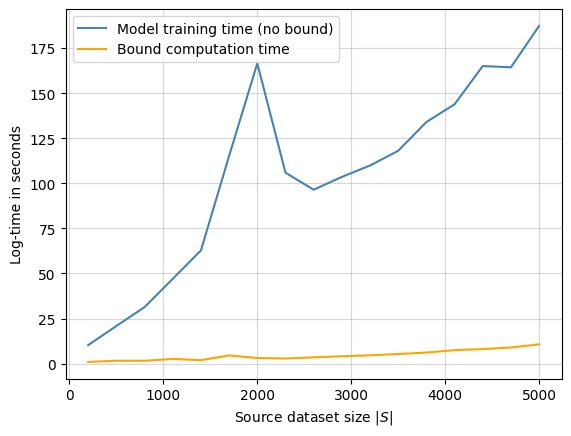

In [248]:
davinz_time_delta = np.array(davinz_results_dict['time_delta'], dtype=float)
print(davinz_time_delta.shape)

training_time_delta = np.array(model_performance_dict['time_training_delta'])
print(training_time_delta.shape)

# Define the x-axis values as the number of epochs
x = np.arange(200, 5300, 300)

# Plot the training loss over epochs
plt.plot(x, training_time_delta[1:], label='Model training time (no bound)', color='steelblue')
plt.plot(x, davinz_time_delta, label='Bound computation time', color='orange')

# Add labels and title to the plot
plt.xlabel("Source dataset size $|S|$")
plt.ylabel("Log-time in seconds")

plt.legend()

plt.grid(alpha=0.5)

# Show the plot
plt.show()

Replace NaN with 0

In [ ]:
sqrt_q_arr = np.array(davinz_results_dict['sqrt_q'])
for i in range(sqrt_q_arr.shape[0]):
    if sqrt_q_arr[i] is None or np.isnan(sqrt_q_arr[i]):
        sqrt_q_arr[i] = 0
davinz_results_dict['sqrt_q'] = list(sqrt_q_arr)
     

mmd_arr = np.array(davinz_results_dict['sqrt_q'])
for i in range(mmd_arr.shape[0]):
    if mmd_arr[i] is None or np.isnan(mmd_arr[i]):
        mmd_arr[i] = 0
davinz_results_dict['mmd'] = list(mmd_arr)

In [ ]:
sqrt_q_arr = np.array(davinz_results_dict['sqrt_q'])
sqrt_q_arr[np.isnan(sqrt_q_arr)] = 0
davinz_results_dict['sqrt_q'] = list(sqrt_q_arr)

### **Compare** Training with DAVinz

In [238]:
n = len(davinz_results_dict['sqrt_q'])
n

17

Compute $\mathcal{k}$

In [239]:
k = np.array(davinz_results_dict['mmd']).sum() / np.array(davinz_results_dict['sqrt_q']).sum()
k

1.0

In [244]:
delta = 0.01

diff_loss_true_history = []
bound_loss_history = []
best_valid_losses = []
for i in range(0, n - 1):
    train_loss_history = model_performance_dict['train_loss_history'][i + 1]
    valid_loss_history = model_performance_dict['valid_loss_history'][i + 1]
    best_valid_loss = np.min(valid_loss_history)
    best_idx = list(np.where(valid_loss_history == best_valid_loss)[0])[0]
    train_loss = train_loss_history[best_idx]

    diff_loss_true = best_valid_loss - train_loss
    diff_loss_true_history.append(diff_loss_true)
    best_valid_losses.append(best_valid_loss)
    
    sqrt_q = davinz_results_dict['sqrt_q'][i]
    mmd = davinz_results_dict['mmd'][i]
    ms = model_performance_dict['dataset_size'][i + 1]
    mt = model_performance_dict['valid_size'] # validation set size
    
    epsilon = 4 * np.sqrt(np.log(4 / delta) / (2 * ms)) + np.sqrt(np.log(4 / delta) / (2 * mt))

    bound_loss = k * sqrt_q + mmd + epsilon
    bound_loss_history.append(bound_loss)

In [245]:
def normalize(x: np.array):
    return x / np.linalg.norm(x)

In [ ]:
bound_loss_history = np.array(bound_loss_history)
diff_loss_true_history = np.array(diff_loss_true_history)
best_valid_losses = np.array(best_valid_losses)

In [181]:
VALID_SIZE = 2000

TRAIN_SIZE = 500
TRAIN_CLASS_1_RATIO = 0.3

N_EPOCHS = 300

NEW_TRAIN_SIZE_MIN = 100
NEW_TRAIN_SIZE_MAX = 3500
NEW_TRAIN_SIZE_STEP = 200
NEW_TRAIN_CLASS_1_RATIO = 0.6
N_EPOCHS_NEW = 500

LEARNING_RATE = 0.0005
DROPOUT_RATE = 0.3

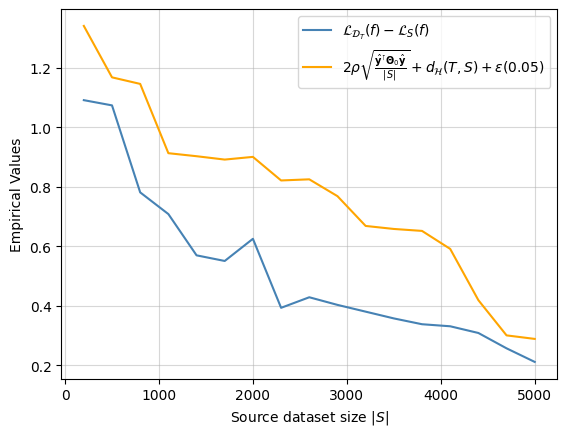

In [184]:
# Define the x-axis values as the number of epochs
x = np.arange(200, 5300, 300)

# Plot the training loss over epochs
plt.plot(x, diff_loss_true_history, label='$\mathcal{L}_{\mathcal{D}_T}(f) - \mathcal{L}_S(f)$', color='steelblue')
plt.plot(x, bound_loss_history, label='$2 \\rho\sqrt{\\frac{\hat{\mathbf{y}}^\intercal \mathbf{\Theta}_0 \hat{\mathbf{y}}}{|S|}} + d_\mathcal{H}(T, S) + \\varepsilon(0.05)$', color='orange')

# Add labels and title to the plot
plt.xlabel("Source dataset size $|S|$")
plt.ylabel("Empirical Values")

plt.legend()

plt.grid(alpha=0.5)

# Show the plot
plt.show()

In [185]:
np.corrcoef(bound_loss_history, diff_loss_true_history)

array([[1.        , 0.91461704],
       [0.91461704, 1.        ]])